In [26]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement 

In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pickle_file_path = "eval.pkl"

records = []
try:
    with open(pickle_file_path, 'rb') as f:
        while True:
            # Load the tensor onto CPU and then move to 'cuda:0'
            record = pickle.load(f)
            records.append(record)
except EOFError:
    # EOFError is raised when pickle reaches the end of the file
    pass


def flatten_recs(records):
    flat_recs = []
    for rec in records:
        flat_recs.extend(rec)
    return flat_recs

In [3]:
import torch
import gc

def clean_mem():
    torch.cuda.empty_cache()
    gc.collect()

In [4]:
records = flatten_recs(records)

In [5]:
recordsdf = pd.DataFrame(records)

In [7]:
def unique_prompt_query(filtered_df):

    df_sorted = filtered_df.sort_values(by='PSNR', ascending=False)
    df_grouped = df_sorted.groupby(['Query', 'Prompt'], as_index=False).first()
    used_prompts = set()
    used_queries = set()

    unique_rows = []
    for index, row in df_grouped.iterrows():
        if row['Prompt'] not in used_prompts and row['Query'] not in used_queries:
            used_prompts.add(row['Prompt'])
            used_queries.add(row['Query'])
            unique_rows.append(row)

    df_unique = pd.DataFrame(unique_rows)

    return df_unique

In [8]:
def plot_metric(title, data_matrix, colorbar_label, num_layers=4):
    """
    Create a heatmap plot of the data matrix with appropriate labels and title.
    
    Parameters:
    title (str): The title of the plot.
    data_matrix (numpy.ndarray): The 2D data matrix to plot.
    colorbar_label (str): The label for the colorbar.
    num_layers (int): The number of concatenated layers in the data_matrix.
    layer_height (int): The original height of each layer before concatenation.
    """
    # Calculate the total width of the concatenated layers
    width = data_matrix.shape[-1]
    layer_height = data_matrix.shape[-2]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    im = plt.imshow(data_matrix, cmap='viridis', aspect='equal')
    plt.colorbar(im, label=colorbar_label)
    plt.title(title, fontsize=16)
    
    # Adjust the x-axis to reflect the layer and token position
    # We assume that each layer has the same width
    layer_width = width // num_layers
    x_ticks = np.arange(0, width, layer_width)
    x_labels = [f'Layer {i+1}' for i in range(num_layers)]
    
    plt.xlabel('Token Position and Layer', fontsize=14)
    plt.xticks(x_ticks, x_labels, rotation='vertical', fontsize=12)
    
    # Adjust the y-axis to reflect the token position in height
    y_ticks = np.arange(0, layer_height, 5)
    y_labels = [str(i) for i in y_ticks]
    
    plt.ylabel('Token Position (Height)', fontsize=14)
    plt.yticks(y_ticks, y_labels, fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_histogram(title, data_matrix, xlabel, bins=1000, log=False):
    
    plt.hist(data_matrix.flatten(), bins=bins, log=log)  # Set log=True for logarithmically spaced bins
    if log:
        plt.xscale('log')  # Set x-axis to be logarithmic
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def reshape_layers(matrix, squeeze=True, dim=-1):
    matrix = matrix.squeeze(1) if squeeze else matrix
    reshaped_matrix = torch.cat(tuple(matrix), dim=dim)
    reshaped_matrix_np = reshaped_matrix.numpy()
    return reshaped_matrix_np

def plot_pca_rgb(pca_rgb_matrix, title, num_layers=4):
    """
    Plot the RGB visualization of PCA coefficients for a given layer.

    Parameters:
    pca_rgb_matrix (numpy.ndarray): An array of shape (num_layers, height, width, 3) containing PCA coefficients.
    layer_idx (int): The index of the layer to visualize.
    """
    # Normalize the PCA coefficients to [0, 1] for valid RGB mapping
    pca_rgb_matrix = (pca_rgb_matrix - pca_rgb_matrix.min()) / (pca_rgb_matrix.max() - pca_rgb_matrix.min())
    
    # Calculate the total width of the concatenated layers
    width = pca_rgb_matrix.shape[-2]
    layer_height = pca_rgb_matrix.shape[-3]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    im = plt.imshow(pca_rgb_matrix, aspect='equal')
    plt.title(title, fontsize=16)
    
    # Adjust the x-axis to reflect the layer and token position
    # We assume that each layer has the same width
    layer_width = width // num_layers
    x_ticks = np.arange(0, width, layer_width)
    x_labels = [f'Layer {i+1}' for i in range(num_layers)]
    
    plt.xlabel('Token Position and Layer', fontsize=14)
    plt.xticks(x_ticks, x_labels, rotation='vertical', fontsize=12)
    
    # Adjust the y-axis to reflect the token position in height
    y_ticks = np.arange(0, layer_height, 5)
    y_labels = [str(i) for i in y_ticks]
    
    plt.ylabel('Token Position (Height)', fontsize=14)
    plt.yticks(y_ticks, y_labels, fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [9]:
def calculate_norm_mse(stacked_matrices):
    # Compute the mean across the examples (0th dimension)
    mean_matrix = torch.mean(stacked_matrices, dim=0)

    # Compute mean squared error
    mse = torch.mean((stacked_matrices - mean_matrix) ** 2, dim=0)

    # Norm along the feature axis (last dimension)
    norm_mse = torch.norm(mse, dim=-1)

    return norm_mse

def calculate_avg_mse(stacked_matrices):
    # Compute the mean across the examples (0th dimension)
    mean_matrix = torch.mean(stacked_matrices, dim=0)

    # Compute mean squared error
    mse = torch.mean((stacked_matrices - mean_matrix) ** 2, dim=0)

    # Norm along the feature axis (last dimension)
    norm_mse = torch.mean(mse, dim=-1)

    return norm_mse

def calculate_norm_mean(stacked_matrices):
    # Compute the mean across the examples (0th dimension)
    mean_matrix = torch.mean(stacked_matrices, dim=0)

    # Norm along the feature axis (last dimension)
    norm_mean = torch.norm(mean_matrix, dim=-1)

    return norm_mean

def calculate_mean_norm(stacked_matrices):
    # Compute the norm of each feature vector
    norm_matrix = torch.norm(stacked_matrices, dim=-1)

    # Mean along the examples dimension
    mean_of_norms = torch.mean(norm_matrix, dim=0)

    return mean_of_norms

def perform_pca_on_features(stacked_matrices, n_components=3):
    """
    Perform PCA on all features across all examples and layers for each token position.
    The result is then reshaped to have RGB values for each token position.
    
    Parameters:
    repr_matrices (list): A list of records, where each record is a dictionary containing 'ReprMatrix'.
    n_components (int): The number of principal components to compute, default is 3 for RGB.
    
    Returns:
    numpy.ndarray: An array of shape (num_layers, height, width, n_components) containing PCA coefficients.
    """    
    # Reshape to form a matrix of shape [num_data_points, num_features]
    # where num_data_points = num_examples * num_layers * height * width
    num_examples, num_layers, _, height, width, num_features = stacked_matrices.shape
    feature_matrix = stacked_matrices.view(-1, num_features).cpu().numpy()

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(feature_matrix)

    # Reshape the result back to (num_layers, height, width, n_components)
    pca_result = pca_result.reshape((num_examples, num_layers, height, width, n_components))
    
    # We'll take the mean across examples to represent the average principal component coefficients
    pca_result = pca_result.mean(axis=0)
    
    return pca_result


In [30]:
#records = torch.stack([a.detach() for a in df_unique['ReprMatrix']])

In [54]:
#recordsdf[0] = recordsdf[0].apply(lambda x: x.split(1, dim=0))
#recordsdf[0] = recordsdf[0].apply(lambda x: torch.cat([t.squeeze(0) for t in x], dim=1))


In [10]:
records = torch.stack([a.detach() for a in recordsdf[0]])

In [11]:
records[0].shape

torch.Size([4, 56, 28, 1024])

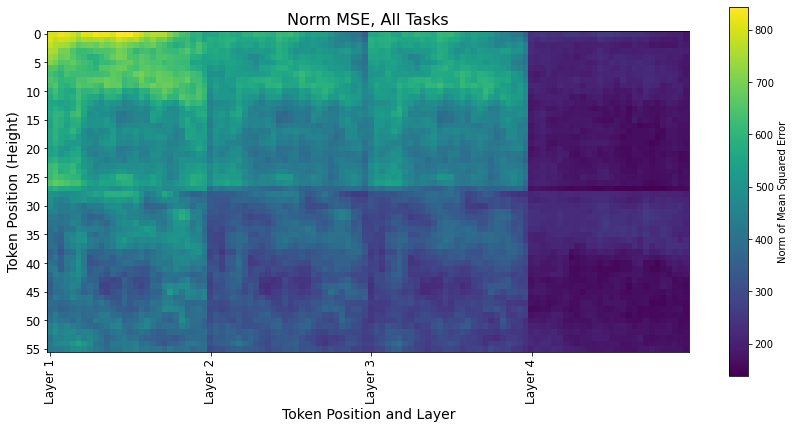

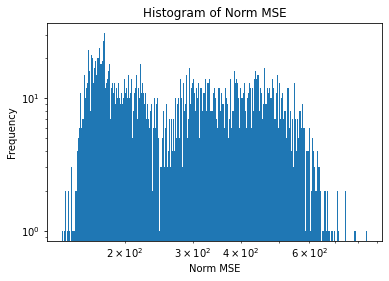

In [14]:
norm_mse_matrix = reshape_layers(calculate_norm_mse(records).cpu())
plot_metric('Norm MSE, All Tasks', norm_mse_matrix, 'Norm of Mean Squared Error')
plot_histogram("Histogram of Norm MSE", norm_mse_matrix, "Norm MSE", log=True)

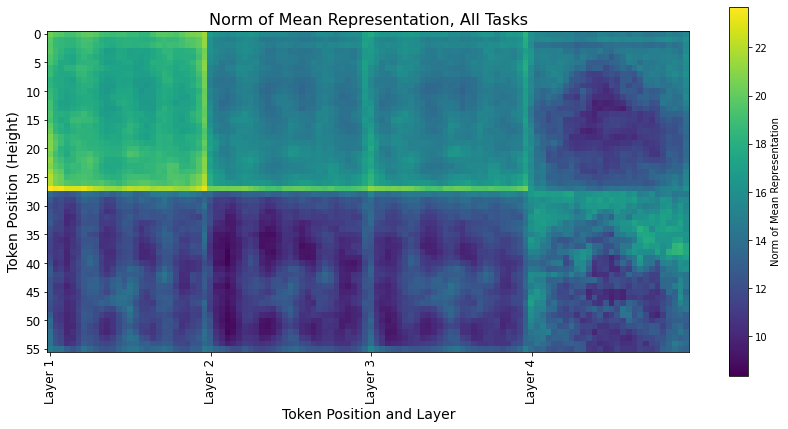

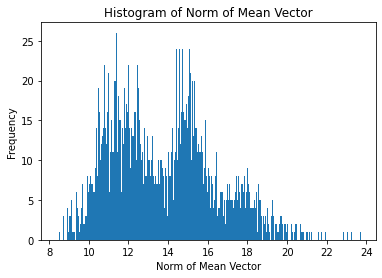

In [17]:
norm_mean_matrix = reshape_layers(calculate_norm_mean(records).cpu())
plot_metric('Norm of Mean Representation, All Tasks', norm_mean_matrix, 'Norm of Mean Representation')
plot_histogram("Histogram of Norm of Mean Vector", norm_mean_matrix, "Norm of Mean Vector")

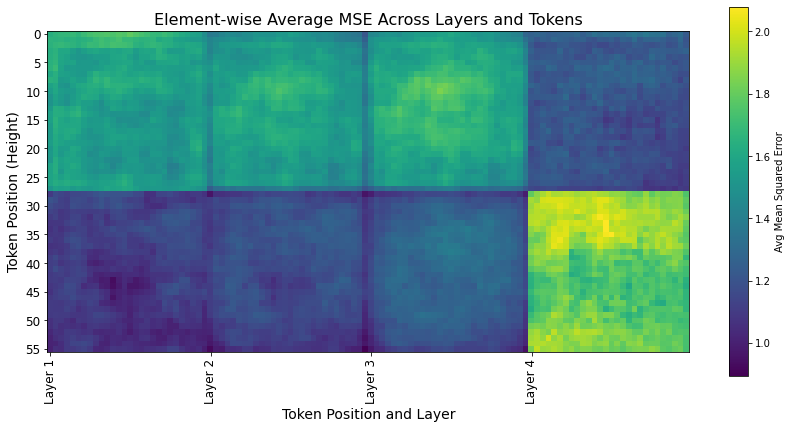

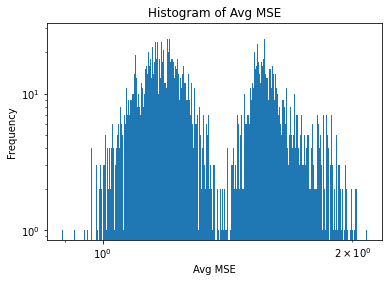

In [18]:
avg_mse_matrix = reshape_layers(calculate_avg_mse(records).cpu())
plot_metric('Element-wise Average MSE Across Layers and Tokens', avg_mse_matrix, 'Avg Mean Squared Error')
plot_histogram("Histogram of Avg MSE", avg_mse_matrix, "Avg MSE", log=True)

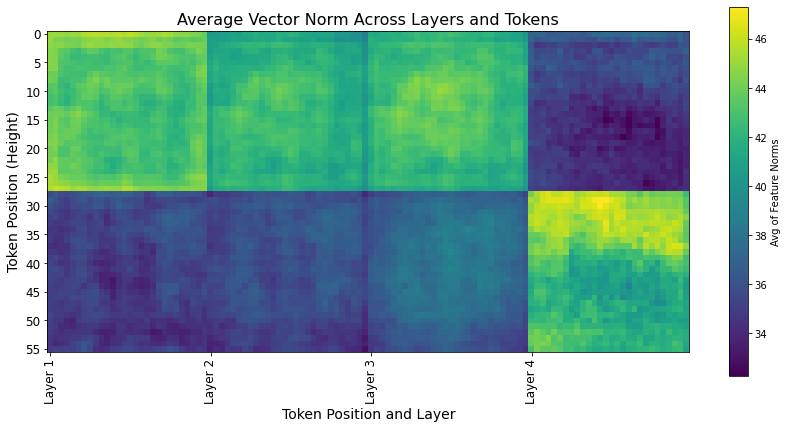

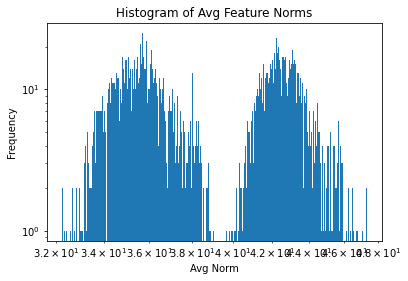

In [19]:
mean_norm_matrix = reshape_layers(calculate_mean_norm(records).cpu())
plot_metric('Average Vector Norm Across Layers and Tokens', mean_norm_matrix, 'Avg of Feature Norms')
plot_histogram("Histogram of Avg Feature Norms", mean_norm_matrix, "Avg Norm", log=True)

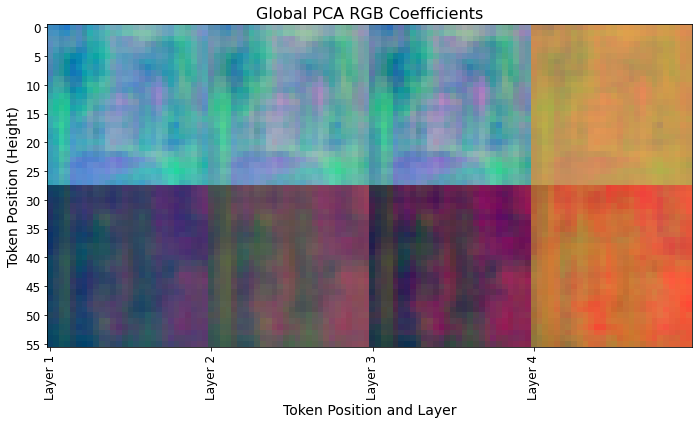

In [42]:
# Calculate PCA coefficients
pca_rgb_matrix = perform_pca_on_features(records)
reshaped_pca_matrix = reshape_layers(torch.from_numpy(pca_rgb_matrix), squeeze=False, dim=-2)

# Plot PCA RGB coefficients for the first layer as an example
plot_pca_rgb(reshaped_pca_matrix, "Global PCA RGB Coefficients")

In [ ]:
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
def reshape_tensor(tensor):
    return tensor.view(4, -1, 1024).permute(1, 0, 2).reshape(-1, 1024)

recordsdf['Reshaped_Features'] = recordsdf[0].apply(lambda x: reshape_tensor(x.to('cuda:1')))

grouped = recordsdf.groupby(1)

pca_results = {}

for category, group in grouped:
    # Stack tensors of the same category
    tensor_list = group['Reshaped_Features'].tolist()
    stacked_tensors = torch.vstack(tensor_list).cpu().numpy()

    # Standardize features
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(stacked_tensors)

    # Apply PCA
    pca = PCA(n_components=2)  # or choose n_components based on your analysis
    principal_components = pca.fit_transform(standardized_data)

    # Store the results
    pca_results[category] = principal_components


In [ ]:
import matplotlib.pyplot as plt

# Assuming pca_results is a dictionary with categories as keys and PCA components as values
# Example format: pca_results = {'Category1': array([...]), 'Category2': array([...]), ...}

# Setting up the plot
plt.figure(figsize=(10, 8))

# Looping through each category to plot
for category, components in pca_results.items():
    plt.scatter(components[:, 0], components[:, 1], alpha=0.5, label=category)

# Adding plot title and labels
plt.title('PCA Results by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from scipy.spatial.distance import euclidean
import numpy as np

centroids = {category: np.mean(components, axis=0) for category, components in pca_results.items()}

# Calculate pairwise distances between centroids of different categories
distances = {}
for category1, centroid1 in centroids.items():
    for category2, centroid2 in centroids.items():
        if category1 != category2:
            # Use a tuple of categories as a key to ensure each pair is only calculated once
            pair = tuple(sorted([category1, category2]))
            if pair not in distances:
                distances[pair] = euclidean(centroid1, centroid2)

categories = list(centroids.keys())

# Initialize an empty DataFrame
distance_matrix = pd.DataFrame(index=categories, columns=categories, data=0)

# Fill in the DataFrame with the distances
for (category1, category2), distance in distances.items():
    distance_matrix.loc[category1, category2] = distance
    distance_matrix.loc[category2, category1] = distance

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, cmap='coolwarm')
plt.title('Inter-Class Centroid Distances')
plt.show()

In [ ]:
import pandas as pd
import torch
from scipy.spatial.distance import euclidean

def average_features(group):
    stacked_tensors = torch.stack(list(group))
    return stacked_tensors.mean(dim=0).cpu()

category_averages = recordsdf.groupby(1)[0].apply(average_features)

# Flatten the tensors for distance computation
category_averages_flat = {cat: avg.view(-1) for cat, avg in category_averages.items()}

# Calculate pairwise distances between category averages
distances = {}
for cat1, avg1 in category_averages_flat.items():
    for cat2, avg2 in category_averages_flat.items():
        if cat1 != cat2:
            pair = tuple(sorted([cat1, cat2]))
            if pair not in distances:
                distances[pair] = euclidean(avg1.numpy(), avg2.numpy())

# distances contains the pairwise distances between the averages of each category
                
stacked_averages = torch.stack(list(category_averages))

distances = torch.norm(stacked_averages.unsqueeze(1) - stacked_averages.unsqueeze(0), dim=-1)

shape = distances.shape[2:]  # Shape [4, 56, 28]
metric_shape = (*shape, 1)   # Shape for the metrics [4, 56, 28, 1]
average_distance = torch.zeros(metric_shape)
median_distance = torch.zeros(metric_shape)
minimum_distance = torch.zeros(metric_shape)
max_distance = torch.zeros(metric_shape)

for a in range(shape[0]):
    for b in range(shape[1]):
        for c in range(shape[2]):
            # Extract distances for the token, excluding the zero distances (same category)
            token_distances = distances[:, :, a, b, c]
            non_zero_distances = token_distances[token_distances != 0]

            # Compute metrics
            average_distance[a, b, c] = non_zero_distances.mean()
            median_distance[a, b, c] = non_zero_distances.median()
            minimum_distance[a, b, c] = non_zero_distances.min()
            max_distance[a, b, c] = non_zero_distances.max()

# Results
average_distance, median_distance, minimum_distance, max_distance

In [86]:
average_distance = average_distance.squeeze()
avg_dist_matrix = reshape_layers(average_distance.cpu())
plot_metric('Average Pairwise Centroid Distances', avg_dist_matrix, 'Avg Distances Between Category Centroids')

median_distance = median_distance.squeeze()
median_dist_matrix = reshape_layers(median_distance.cpu())
plot_metric('Median Pairwise Centroid Distances', median_dist_matrix, 'Median Distances Between Category Centroids')

minimum_distance = minimum_distance.squeeze()
min_dist_matrix = reshape_layers(median_distance.cpu())
plot_metric('Minimum Pairwise Centroid Distances', min_dist_matrix, 'Minimum Distances Between Category Centroids')

max_distance = max_distance.squeeze()
max_dist_matrix = reshape_layers(max_distance.cpu())
plot_metric('Max Pairwise Centroid Distances', max_dist_matrix, 'Max Distances Between Category Centroids')

torch.Size([8, 4, 56, 28, 1])

In [ ]:
recordsdf['Key_Features'] = recordsdf[0].apply(lambda x: x[3,28:31,0:6].reshape((3*6,1024)))


In [ ]:
recordsdf['Key_Features_Stacked'] = recordsdf["Key_Features"].apply(lambda x: x.reshape((3*6*1024)))
recordsdf['Key_Features_Avg'] = recordsdf["Key_Features"].apply(lambda x: x.mean(0))
recordsdf['Key_Features_Max'] = recordsdf["Key_Features"].apply(lambda x: x.max(dim=0).values)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch

# Example DataFrame setup
# recordsdf = pd.DataFrame({'Category': ['A', 'B', ...], 'Key_Features': [tensor1, tensor2, ...]})

# Concatenate all features
all_features = torch.vstack(list(recordsdf['Key_Features'])).cpu().numpy()

# Standardize the features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# Apply PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = recordsdf[1].unique()

# Each Key_Feature tensor contains multiple records, so repeat the category labels accordingly
repeated_categories = np.repeat(recordsdf[1], [len(features) for features in recordsdf['Key_Features']])

for category in categories:
    # Select rows that belong to the current category
    indices = repeated_categories == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

all_features = torch.vstack(list(recordsdf['Key_Features'])).cpu().numpy()


# Standardize the features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# Apply PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(all_features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = recordsdf[1].unique()
for category in categories:
    # Select rows that belong to the current category
    indices = recordsdf[1] == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

pca = PCA()
features_2d = pca.fit_transform(all_features_scaled)

# Plotting the variance captured by each principal component
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, color='g', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.title('Variance Captured by each Principal Component')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame with 'Category' and 'Feature' columns
# Example: df = pd.DataFrame({'Category': ['A', 'A', 'B', 'B'], 'Feature': [feature1, feature2, feature3, feature4]})

# Concatenate all features
all_features = torch.vstack(list(recordsdf['Key_Features_Stacked'])).cpu().numpy()

# Standardize the features
scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features_scaled)

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = recordsdf[1].unique()
for category in categories:
    # Select rows that belong to the current category
    indices = recordsdf[1] == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('t-SNE Projection Colored by Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Places the legend to the right of the plot

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()